<a href="https://colab.research.google.com/github/ddoneu/ECON3916-Statistical-Machine-Learning/blob/main/Lab4/%20Lab4_Descriptive_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64


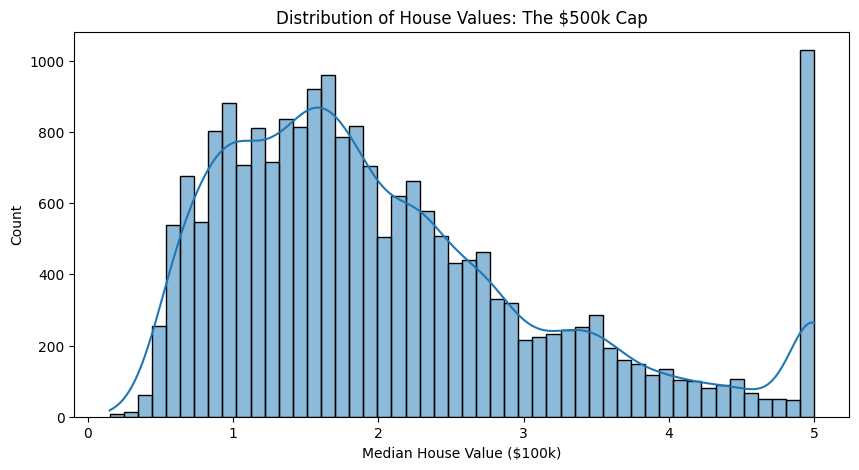

In [7]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. Ingest Data
data = fetch_california_housing(as_frame=True)
df = data.frame
df.describe()

# 2. Inspect the "Ceiling Effect"
print(df['MedHouseVal'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df['MedHouseVal'], bins=50, kde=True)
plt.title("Distribution of House Values: The $500k Cap")
plt.xlabel("Median House Value ($100k)")
plt.show()



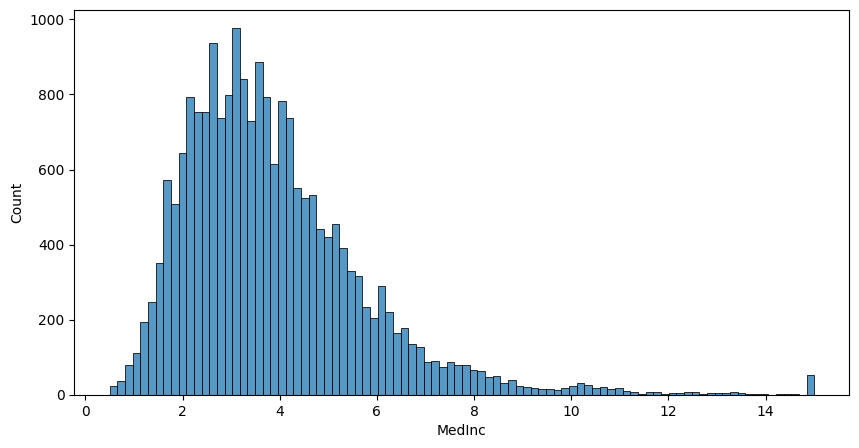

In [8]:
plt.figure(figsize=(10, 5))
sns.histplot(df['MedInc'])
plt.show()

In [9]:
def flag_outliers_iqr(df, column):
    # Calculate Quartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the "Tukey Fence"
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Return Boolean Mask
    return (df[column] < lower_bound) | (df[column] > upper_bound)

# Apply to Median Income
df['outlier_iqr'] = flag_outliers_iqr(df, 'MedInc')

print(f"Manual Outliers Detected: {df['outlier_iqr'].sum()}")
print("These are primarily the 'Wealthy' districts.")

Manual Outliers Detected: 681
These are primarily the 'Wealthy' districts.


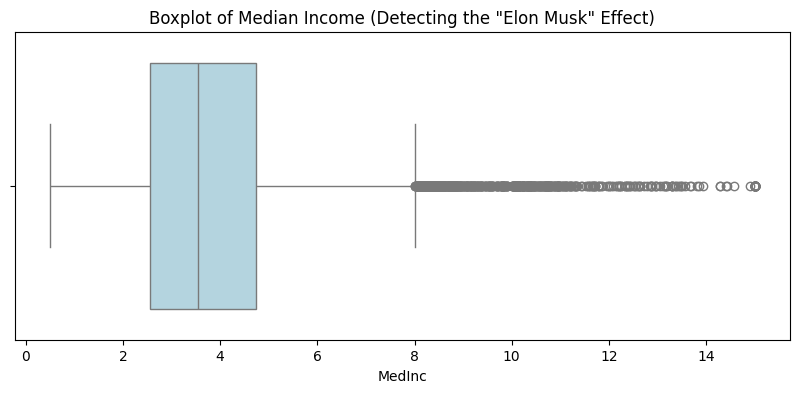

In [10]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['MedInc'], color='lightblue')
plt.title('Boxplot of Median Income (Detecting the "Elon Musk" Effect)')
plt.show()


In [20]:
# Initialize the model
# contamination=0.05: We estimate ~5% of the data is anomalous
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=3916)

# Features to analyze (Income, House Age, Average Rooms)
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population']

# Fit and Predict (-1 = Outlier, 1 = Normal)
preds = iso_forest.fit_predict(df[features])

# Map to boolean (True if outlier)
df['outlier_iso'] = preds == -1

print(f"Algorithmic Outliers Detected: {df['outlier_iso'].sum()}")

Algorithmic Outliers Detected: 1032


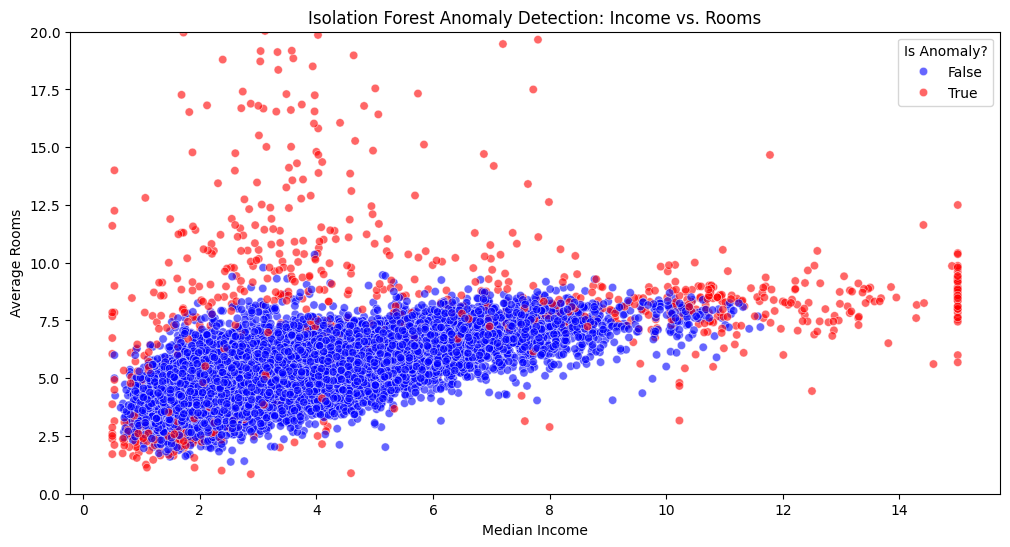

In [19]:
plt.figure(figsize=(12, 6))

# Plot points flagged by Isolation Forest
sns.scatterplot(
    data=df,
    x='MedInc',
    y='AveRooms',
    hue='outlier_iso',
    palette={True: 'red', False: 'blue'},
    alpha=0.6
)

plt.title("Isolation Forest Anomaly Detection: Income vs. Rooms")
plt.xlabel("Median Income")
plt.ylabel("Average Rooms")
plt.ylim(0, 20) # Zoom in to ignore extreme errors
plt.legend(title='Is Anomaly?')
plt.show()


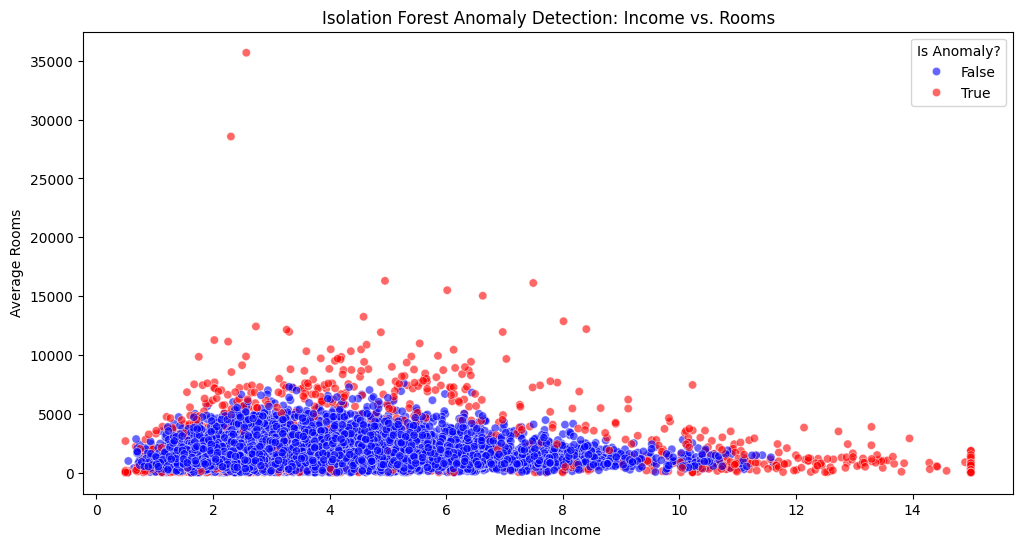

In [17]:
plt.figure(figsize=(12, 6))

# Plot points flagged by Isolation Forest
sns.scatterplot(
    data=df,
    x='MedInc',
    y='Population',
    hue='outlier_iso',
    palette={True: 'red', False: 'blue'},
    alpha=0.6
)

plt.title("Isolation Forest Anomaly Detection: Income vs. Rooms")
plt.xlabel("Median Income")
plt.ylabel("Average Rooms")
plt.legend(title='Is Anomaly?')
plt.show()


Dataset Split:
  Normal points: 19,608
  Outlier points: 1,032
  Outlier rate: 5.00%

COMPARATIVE FORENSICS REPORT: Outliers vs Normal Market

📊 CENTRAL TENDENCY ANALYSIS
----------------------------------------------------------------------
Metric                    Normal               Outlier             
----------------------------------------------------------------------
MedInc (Mean)             $    3.75         $    6.20
MedInc (Median)           $    3.51         $    4.89
MedHouseVal (Mean)        $    2.03         $    2.78
MedHouseVal (Median)      $    1.78         $    2.25

📉 VOLATILITY ANALYSIS (StdDev vs MAD)
----------------------------------------------------------------------
Metric                    Normal               Outlier             
----------------------------------------------------------------------
MedInc (StdDev)              1.623              4.058
MedInc (MAD)                 1.033              2.587
MedHouseVal (StdDev)         1.109            

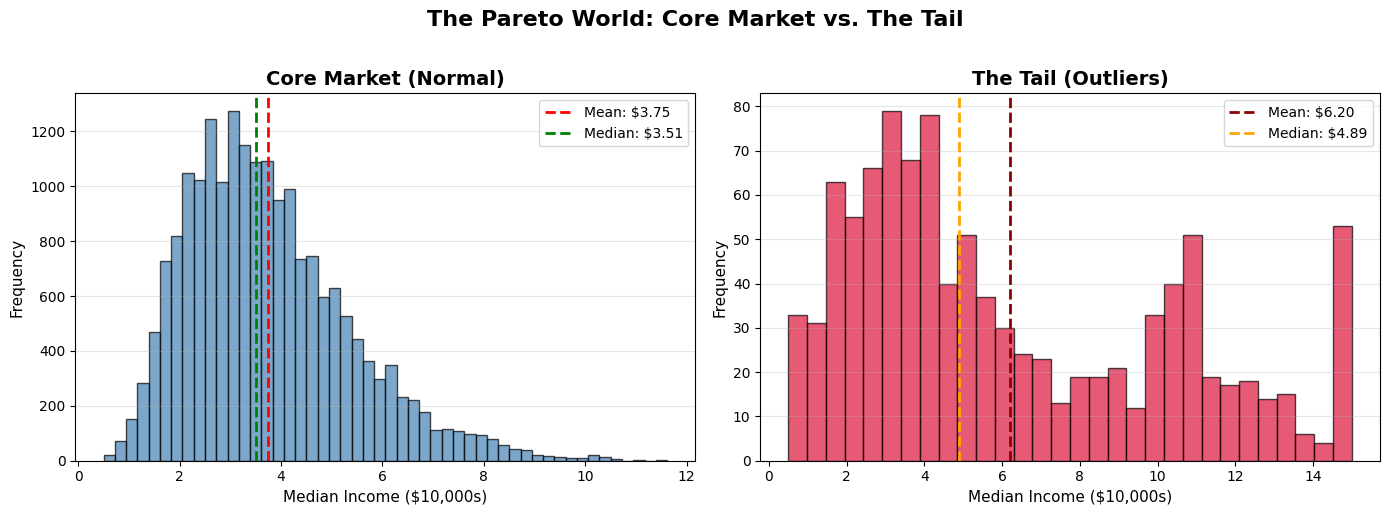


✅ Report Complete!


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation

# Assuming you have a DataFrame 'df' with columns:
# 'MedInc', 'MedHouseVal', 'outlier_iso' (boolean)

# 1. Split data into normal and outlier groups
df_normal = df[df['outlier_iso'] == False].copy()
df_outlier = df[df['outlier_iso'] == True].copy()

print(f"Dataset Split:")
print(f"  Normal points: {len(df_normal):,}")
print(f"  Outlier points: {len(df_outlier):,}")
print(f"  Outlier rate: {len(df_outlier)/len(df)*100:.2f}%\n")

# 2. Calculate Mean and Median for both groups
metrics = {}

for group_name, group_df in [('Normal', df_normal), ('Outlier', df_outlier)]:
    metrics[group_name] = {
        'MedInc_Mean': group_df['MedInc'].mean(),
        'MedInc_Median': group_df['MedInc'].median(),
        'MedHouseVal_Mean': group_df['MedHouseVal'].mean(),
        'MedHouseVal_Median': group_df['MedHouseVal'].median(),
    }

# 3. Calculate Standard Deviation vs MAD for volatility analysis
for group_name, group_df in [('Normal', df_normal), ('Outlier', df_outlier)]:
    metrics[group_name]['MedInc_StdDev'] = group_df['MedInc'].std()
    metrics[group_name]['MedInc_MAD'] = median_abs_deviation(group_df['MedInc'], nan_policy='omit')
    metrics[group_name]['MedHouseVal_StdDev'] = group_df['MedHouseVal'].std()
    metrics[group_name]['MedHouseVal_MAD'] = median_abs_deviation(group_df['MedHouseVal'], nan_policy='omit')

# 4. Calculate Inequality Wedge (Mean - Median)
print("="*70)
print("COMPARATIVE FORENSICS REPORT: Outliers vs Normal Market")
print("="*70)

print("\n📊 CENTRAL TENDENCY ANALYSIS")
print("-"*70)
print(f"{'Metric':<25} {'Normal':<20} {'Outlier':<20}")
print("-"*70)
print(f"{'MedInc (Mean)':<25} ${metrics['Normal']['MedInc_Mean']:>8.2f}         ${metrics['Outlier']['MedInc_Mean']:>8.2f}")
print(f"{'MedInc (Median)':<25} ${metrics['Normal']['MedInc_Median']:>8.2f}         ${metrics['Outlier']['MedInc_Median']:>8.2f}")
print(f"{'MedHouseVal (Mean)':<25} ${metrics['Normal']['MedHouseVal_Mean']:>8.2f}         ${metrics['Outlier']['MedHouseVal_Mean']:>8.2f}")
print(f"{'MedHouseVal (Median)':<25} ${metrics['Normal']['MedHouseVal_Median']:>8.2f}         ${metrics['Outlier']['MedHouseVal_Median']:>8.2f}")

print("\n📉 VOLATILITY ANALYSIS (StdDev vs MAD)")
print("-"*70)
print(f"{'Metric':<25} {'Normal':<20} {'Outlier':<20}")
print("-"*70)
print(f"{'MedInc (StdDev)':<25} {metrics['Normal']['MedInc_StdDev']:>8.3f}           {metrics['Outlier']['MedInc_StdDev']:>8.3f}")
print(f"{'MedInc (MAD)':<25} {metrics['Normal']['MedInc_MAD']:>8.3f}           {metrics['Outlier']['MedInc_MAD']:>8.3f}")
print(f"{'MedHouseVal (StdDev)':<25} {metrics['Normal']['MedHouseVal_StdDev']:>8.3f}           {metrics['Outlier']['MedHouseVal_StdDev']:>8.3f}")
print(f"{'MedHouseVal (MAD)':<25} {metrics['Normal']['MedHouseVal_MAD']:>8.3f}           {metrics['Outlier']['MedHouseVal_MAD']:>8.3f}")

print("\n🔺 INEQUALITY WEDGE ANALYSIS (Mean - Median)")
print("-"*70)
outlier_inc_wedge = metrics['Outlier']['MedInc_Mean'] - metrics['Outlier']['MedInc_Median']
outlier_val_wedge = metrics['Outlier']['MedHouseVal_Mean'] - metrics['Outlier']['MedHouseVal_Median']
normal_inc_wedge = metrics['Normal']['MedInc_Mean'] - metrics['Normal']['MedInc_Median']
normal_val_wedge = metrics['Normal']['MedHouseVal_Mean'] - metrics['Normal']['MedHouseVal_Median']

print(f"{'Variable':<25} {'Normal Wedge':<20} {'Outlier Wedge':<20}")
print("-"*70)
print(f"{'MedInc':<25} ${normal_inc_wedge:>8.3f}           ${outlier_inc_wedge:>8.3f}")
print(f"{'MedHouseVal':<25} ${normal_val_wedge:>8.3f}           ${outlier_val_wedge:>8.3f}")

print("\n💡 INTERPRETATION:")
if outlier_inc_wedge > normal_inc_wedge:
    print(f"  → Outliers show HIGHER inequality (Mean > Median by ${outlier_inc_wedge:.2f})")
    print(f"  → This suggests right-skewed distribution in outlier income")
else:
    print(f"  → Outliers show LOWER inequality than normal market")

print("="*70)

# VISUALIZATION
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Normal Distribution
axes[0].hist(df_normal['MedInc'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(metrics['Normal']['MedInc_Mean'], color='red', linestyle='--', linewidth=2, label=f"Mean: ${metrics['Normal']['MedInc_Mean']:.2f}")
axes[0].axvline(metrics['Normal']['MedInc_Median'], color='green', linestyle='--', linewidth=2, label=f"Median: ${metrics['Normal']['MedInc_Median']:.2f}")
axes[0].set_title('Core Market (Normal)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Median Income ($10,000s)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Right: Outlier Distribution
axes[1].hist(df_outlier['MedInc'], bins=30, color='crimson', alpha=0.7, edgecolor='black')
axes[1].axvline(metrics['Outlier']['MedInc_Mean'], color='darkred', linestyle='--', linewidth=2, label=f"Mean: ${metrics['Outlier']['MedInc_Mean']:.2f}")
axes[1].axvline(metrics['Outlier']['MedInc_Median'], color='orange', linestyle='--', linewidth=2, label=f"Median: ${metrics['Outlier']['MedInc_Median']:.2f}")
axes[1].set_title('The Tail (Outliers)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Median Income ($10,000s)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle('The Pareto World: Core Market vs. The Tail',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✅ Report Complete!")